# Tải thư viện và các file liên quan

Import một số thư viện

In [7]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import os

Kết nối xuống driver

In [3]:
#Connect to gg drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Tải trained glove và dataset

In [4]:
os.chdir("/content/drive/My Drive/Colab Notebooks/Source_code/LSTM_data/LSTM_dataset")

In [5]:
raw_data = pd.read_csv('preprocessed_LSTM_dataset.csv')
raw_data.clean_text = raw_data.clean_text.astype(str)

In [6]:
raw_data

,text,sentiment,rate,tokens,clean_text
0,The camera is very slow :(,neutral,3.0,"['camera', 'slow']",camera slow
1,I was happy I got a case and a charger that wa...,negative,1.0,"['happy', 'got', 'case', 'charger', 'descripti...",happy got case charger description told phone ...
2,I bought this phone for my wife and I wanted t...,positive,5.0,"['bought', 'phone', 'wife', 'wanted', 'wait', ...",bought phone wife wanted wait month half leave...
3,HTC One in White is good; in black it is bette...,positive,5.0,"['tc', 'one', 'white', 'good', 'black', 'bette...",tc one white good black better love new phone ...
4,This phone is definitely one of the fastest on...,positive,5.0,"['phone', 'definitely', 'one', 'fastest', 'mar...",phone definitely one fastest market moment dro...
...,...,...,...,...,...
89995,Fast but hot. Which makes it run slower in hig...,neutral,3.0,"['fast', 'hot', 'makes', 'run', 'slower', 'hig...",fast hot makes run slower high temperature sit...
89996,no devise help,neutral,3.0,"['no', 'devise', 'help']",no devise help
89997,I love the watch/phone and everything it offer...,neutral,3.0,"['love', 'watch', 'phone', 'everything', 'offe...",love watch phone everything offered keep freez...
89998,Replacement,neutral,3.0,['replacement'],replacement


In [8]:
data = raw_data

In [9]:
os.chdir("/content/drive/My Drive/Colab Notebooks/Source_code/Corpus")

In [10]:
# Load glove into emmbed_dict
emmbed_dict = {}
with open('Glove_pre_trained_300d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector

In [11]:
emmbed_dict['the'].shape[0]

300

# Thực hiện tokenize và xây dựng mô hình

Thực hiện Tokenize đoạn văn bản

In [12]:
vocab_size = 15000

tokenizer = Tokenizer(split=' ', num_words = vocab_size)
tokenizer.fit_on_texts(data['clean_text'].values)
print()
X = tokenizer.texts_to_sequences(data['clean_text'].values) #convert data to number
X = pad_sequences(X) # padding
print(X.shape[1]) #check size
MAX_LEN = X.shape[1]
words_to_index = tokenizer.word_index


1607


In [13]:
# Select only top 15000 words in word index
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

top_n_words_index = dict(take(vocab_size, words_to_index.items()))
len(top_n_words_index)

15000

Khởi tạo model LSTM

In [14]:
inp_dim = vocab_size+1 #dimensions for one-hot encoding of embedding layer, +1 means include index 0
embed_dim = emmbed_dict['mobile'].shape[0]
hidden_nodes = 150 #dimension of LSTM output
output_dim = 3

print(vocab_size)
print(inp_dim)

15000
15001


In [15]:
# Create weighten matrix of glove
emb_matrix = np.zeros((inp_dim, embed_dim))
for word, index in top_n_words_index.items():
  embedding_vector = emmbed_dict.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

In [17]:
os.chdir("/content/drive/My Drive/Colab Notebooks/Source_code/LSTM_data/LSTM_trained_Glove/LSTM_Glove_trained_300D")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1607, 300)         4500300   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 1607, 300)        0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 150)               270600    
                                                                 
 dense_1 (Dense)             (None, 3)                 453       
                                                                 
Total params: 4,771,353
Trainable params: 271,053
Non-trainable params: 4,500,300
_________________________________________________________________
None


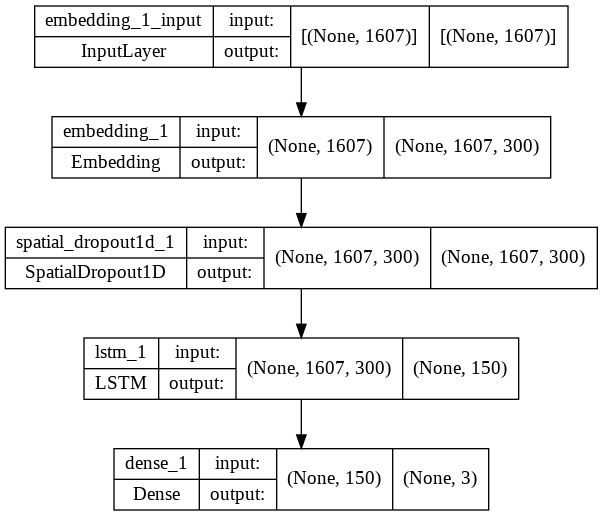

In [18]:
model = Sequential()
#Embedding each row of X ("X.shape[1]" len) into dense vectors "embed_dim" 
model.add(Embedding(input_dim = inp_dim, output_dim = embed_dim, input_length = MAX_LEN, weights = [emb_matrix], trainable=False)) 
model.add(SpatialDropout1D(0.4))
model.add(LSTM(hidden_nodes, dropout=0.2, recurrent_dropout=0.2))  # add return_sequences=True if you want many-to-many LSTM model
model.add(Dense(output_dim,activation='softmax')) 
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Tạo tập train test và tiến hành huấn luyện mô hình

Tạo tập train và test

In [ ]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(72000, 1607) (72000, 3)
(18000, 1607) (18000, 3)


In [ ]:
Y_train

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]], dtype=uint8)

Thực hiện train network 

In [ ]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 4, batch_size=batch_size, verbose = 1)

Epoch 1/4
2250/2250 [==============================] - 5344s 2s/step - loss: 0.7172 - accuracy: 0.6769
Epoch 2/4
2250/2250 [==============================] - 5340s 2s/step - loss: 0.6008 - accuracy: 0.7409
Epoch 3/4
2250/2250 [==============================] - 5347s 2s/step - loss: 0.5565 - accuracy: 0.7614
Epoch 4/4
2250/2250 [==============================] - 5343s 2s/step - loss: 0.5243 - accuracy: 0.7788


Lưu model xuống drive

In [ ]:
#Save model
model.save('LSTM_Model.h5')

In [ ]:
#Save training and testing
from numpy import savetxt
savetxt('X_train.csv', X_train, delimiter=',')
savetxt('Y_train.csv', Y_train, delimiter=',')
savetxt('X_test.csv', X_test, delimiter=',')
savetxt('Y_test.csv', Y_test, delimiter=',')

In [ ]:
#Save tokenizer
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('MAX_LEN.txt', 'w') as f:
  f.write('%d' % MAX_LEN)

# Thử nghiệm và đánh giá mô hình

Test sử dụng LSTM

In [ ]:
test = ["""product bad never buy"""]
#vectorizing the test by the pre-fitted tokenizer instance
test = tokenizer.texts_to_sequences(test)
#padding the test to have exactly the same shape as `embedding_2` input
test = pad_sequences(test, maxlen=MAX_LEN, dtype='int32', value=0)
print(test)
sentiment = model.predict(test,batch_size=1,verbose = 2)[0]
np.argmax(sentiment)
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("neutral")
elif(np.argmax(sentiment) == 2):
  print("positive")

[[ 0  0  0 ... 57 52 23]]
1/1 - 0s - 391ms/epoch - 391ms/step
negative


Validation và evaluation

In [ ]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

516/516 - 196s - loss: 0.4983 - accuracy: 0.7955 - 196s/epoch - 379ms/step
score: 0.50
acc: 0.80


Dropout: 20% - https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046


Tham khảo: https://colab.research.google.com/drive/1fAuZ7L8YQZrF-MyRXrdyR-Dh13AfA_X0

https://towardsdatascience.com/sentiment-analysis-using-lstm-and-glove-embeddings-99223a87fe8e